# Experiments [1.4.1] [1.4.2] [1.4.3] - Heatmaps
Execute notebook per dataset separately

In [1]:
def param_default():
    return {
        'model': 'codeparrot',
        'dataset' : 'DC_SG_BD', #### CHANGE
        'modality' : 'sc',
        'datasets' : {
            'SG_BD' : 'code_completion_random_cut_5k_30_512_tokens', 
            'DC_SG_BD' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens', 
            'DC_SG' : 'code_completion_docstring_signature_3.8k_30_150_tokens', 
            'DC': 'code_completion_docstring_5k_30_150_tokens'
        },
        'num_experiments' : 30, 
        'bootstrapping_size': 500,
        ################ INPUT
        'global_taxonomy_results': '/workspaces/code-rationales/data/global_taxonomy_results/gpt',
        ################ OUTPUT
        'quantitative_results' : '/workspaces/code-rationales/data/experiments/quantitative_results',
        'plot_values_results' : '/workspaces/code-rationales/data/experiments/plot_values_results',
        'grouping_results' : '/workspaces/code-rationales/data/experiments/grouping_results', 
    }
params = param_default()

## Source Code

### Imports

In [2]:
import json
import pandas as pd
import numpy as np
import math
from statistics import NormalDist

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pd.options.display.float_format = '{:.2f}'.format

In [3]:
from code_rationales.taxonomies import *
import os.path

### Dictionary Flatting

In [4]:
def flat_global_results(experiment_global_result: dict):
    flatten_results = { key: [] for key in experiment_global_result.keys() } ## There are 31 fixed categories
    for target_key, rationales in experiment_global_result.items():
        for rational_key, rational_values in rationales.items():
            flatten_results[rational_key] += rational_values
    return flatten_results

### Statistics

In [5]:
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [6]:
def confidence_intervals_large_samples(data, confidence=0.95):
    """
    @confidence: confidence interval 
    @return: tuple (lowerbound, uperbound, h-value)
    """
    dist = NormalDist.from_samples( data )
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [7]:
def boostrap_dictionary(dictionary: dict, size):
    boostrapped_dict = {}
    for key, values in dictionary.items():
        if values:
            boostrapped_dict[key] = bootstrapping(values, np.mean, size)
    return boostrapped_dict

### Data processing


In [8]:
def clean_results(global_results):
    def clean_dictonary(result_dict):
        clean_dict = result_dict.copy()
        for key, value in result_dict.items():
            if not value:
                clean_dict.pop(key)
        return clean_dict
    for key, value in global_results.items():
        global_results[key] = clean_dictonary(value)
    return clean_dictonary(global_results)

In [9]:
def get_experiments_dfs(experients_global_results):
    experiment_dfs = []
    for experiment in experients_global_results:
        experiment = flat_global_results(experiment)
        experiment = boostrap_dictionary(dictionary=experiment, size=params['bootstrapping_size'])
        experiment_dfs.append(pd.DataFrame(experiment))
    return experiment_dfs

In [10]:
### REDUCE EXPERIMENTS FOR HEATMAPS
def reduce_rationales_df(experients_global_results: dict, target_list: list, source_list: list):
    reduced_rationales_df = {target: {rational: [] for rational in source_list} for target in target_list}
    for experient_global_result in experients_global_results:
        target_dictionary = {key: value for key, value in experient_global_result.items() if key in target_list}
        for target_key in target_dictionary.keys():
            target_dictionary[target_key] = {key: np.median(bootstrapping(value, np.mean, 100)) # MEDIAN FOR EXPERIMENT RESULT
                                             for key, value in target_dictionary[target_key].items() if key in source_list}
            for rational_key in target_dictionary[target_key].keys():
                reduced_rationales_df[target_key][rational_key].append(target_dictionary[target_key][rational_key])
    for target_key in reduced_rationales_df.keys():
        reduced_rationales_df[target_key] = boostrap_dictionary(reduced_rationales_df[target_key], 100)
    return reduced_rationales_df         

In [11]:
def create_data_to_plot(experients_global_results, target_list, source_list, name):
    file_path = params['plot_values_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '___' + name + '.csv'
    if os.path.isfile(file_path):
          reduced_df = pd.read_csv(file_path, index_col=[0])
          return reduced_df
    reduced_rationales_global_results_df = pd.DataFrame(reduce_rationales_df(experients_global_results, target_list, source_list)).fillna(0)
    for column in reduced_rationales_global_results_df.columns:
            reduced_rationales_global_results_df[column] = reduced_rationales_global_results_df[column].apply(lambda value: np.median(value))
    reduced_rationales_global_results_df.to_csv(file_path)
    return reduced_rationales_global_results_df

### Grouping Storing

In [12]:
def store_groupings(global_results: list, path:str):
    with open(path, 'w') as output_file: 
        json.dump(global_results, output_file)

In [13]:
def open_groupings(path:str):
    with open(path, 'r') as output_file:
        data = json.load(output_file)
    return data

### Grouping

In [14]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'

In [15]:
def get_experiments_results(results_folder, name:str):
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    experiment_paths = [get_experiment_path(results_folder, params['datasets'][params['dataset']], exp) for exp in range(params['num_experiments'])]
    experiment_global_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_global_results.append(json.loads(file.read()))
    store_groupings(experiment_global_results, file_path)
    return experiment_global_results

In [16]:
def get_global_results_category_by_groups(experients_global_results: list, name: str):
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {category: {group: [] for group in global_groups().keys()} for category in experiment_result.keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[target_category][list(filter(lambda group: rational_category in global_groups()[group], global_groups().keys()))[0]] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    store_groupings(global_results_by_groups, file_path)
    return global_results_by_groups

In [17]:
def get_global_results_group_by_categories(experients_global_results: list, name: str):
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {group: {category: [] for category in experiment_result.keys()} for group in global_groups().keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[list(filter(lambda group: target_category in global_groups()[group], global_groups().keys()))[0]][rational_category] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    store_groupings(global_results_by_groups, file_path)
    return global_results_by_groups

In [18]:
def get_global_results_group_by_groups(experients_global_results: list, name: str): 
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {group_target: {group_rational: [] for group_rational in global_groups().keys()} for group_target in global_groups().keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[list(filter(lambda group: target_category in global_groups()[group], global_groups().keys()))[0]][list(filter(lambda group: rational_category in global_groups()[group], global_groups().keys()))[0]] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    store_groupings(global_results_by_groups, file_path)
    return global_results_by_groups

In [19]:
def get_reduced_rationales_results(name, experiments_results: dict, target_list: list, source_list: list,):
    reduced_rationales_global_results_df = create_data_to_plot(experiments_results, target_list, source_list, name)
    reduced_rationales_global_results_df = reduced_rationales_global_results_df.sort_index().sort_index(axis=1)
    return reduced_rationales_global_results_df

### Visualization

In [20]:
def print_heatmap(
        reduced_rationales_global_results_df,
        ylabel: str, 
        xlabel: str,
        fig_size = (10,10), 
        font = 20, 
        vmax = 0.22
):        
        #cmap = LinearSegmentedColormap.from_list('custom_map', ['black','green'], N=128)
        #cmap = "YlGnBu"

        plt.rcParams.update({'font.size': font})
        ax = plt.axes()
        sns.set(rc = {'figure.figsize':fig_size})
        sns.heatmap(reduced_rationales_global_results_df, 
                    #cmap=cmap, 
                    vmin=0, vmax=vmax,
                    ax=ax)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show
        pass

### Analysis - Rational Concept - Countings

In [21]:
def create_frequencies_dataframe(experients_global_results: list):
    frequencies_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        frequencies_df = frequencies_df.append({key: len(value) for key, value in rationales_results.items()}, ignore_index=True)
    frequencies_df = frequencies_df.fillna(0)   
    return frequencies_df


### Analysis - Rational Concept - Bootstrapping probability

In [22]:
# Function to fill NaN values with random chose from a specified array
def fill_nan_with_random_col(col):
    if col.isna().sum() == 0:
        return col
    random_values = np.random.choice(col[col.notna()].to_list(), col.isna().sum())
    col[col.isna()] = random_values
    return col

In [23]:
def create_bootstapped_dataframe(experients_global_results:list):
    bootstrapped_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        rationales_results = boostrap_dictionary(dictionary=rationales_results, size=params['bootstrapping_size'])
        bootstrapped_df = bootstrapped_df.append({key: np.median(value) for key, value in rationales_results.items()}, ignore_index=True)
    return bootstrapped_df

### Calculate statistics and get results DF

In [24]:
### CREATE GROUP FREQUENCY RESULTS
def calculate_results(global_dataframe):
    results_df = pd.DataFrame(columns=['type', 'group', 'category', 'mean', 'median', 'std', 'ci'])
    for category in global_dataframe.columns:
        experiments_values = global_dataframe[category].tolist()
        try:
            group = [key for key, value in global_groups().items() if category in value][0] ## Mapping from taxonomy groups
        except Exception as e:
            print(e)
        results_df = results_df.append({
            'type': group.split('_')[0], 
            'group': group, 
            'category': category, 
            'median' : np.median(experiments_values),
            'mean' : np.mean(experiments_values), 
            'std' : np.std(experiments_values),
            'ci' : confidence_intervals_large_samples(experiments_values)
        }, ignore_index=True)
    return results_df.sort_values(by='median', ascending=False).reset_index(drop=True)

### Create Groupings

In [25]:
experiments_global_results = get_experiments_results(params['global_taxonomy_results'], 'level_1')
global_results_category_by_groups = get_global_results_category_by_groups(experiments_global_results, 'level_2_1')
global_results_group_by_categories = get_global_results_group_by_categories(experiments_global_results, 'level_1_2')
global_results_groups_by_groups = get_global_results_group_by_groups(experiments_global_results, 'level_2')

### Frequency Analysis

In [26]:
global_frequencies_dataframe = create_frequencies_dataframe(experiments_global_results)
global_frequencies_dataframe

,punctuation,exceptions,oop,asserts,types,conditionals,loops,operators,indentation,bool,...,nl_pronoun,nl_adverb,nl_adjetive,nl_determiner,nl_preposition,nl_particle,nl_modal,nl_conjunction,nl_cardinal,nl_other
0,209452,7170,17089,1177,102664,5391,1879,35850,396367,1318,...,3801,11351,37943,50423,55014,131,3687,17943,3635,40246
1,206115,8280,16253,1212,95027,5004,2283,36222,378368,1872,...,3411,9100,38739,48037,52688,238,2341,17405,4309,39219
2,184980,9635,15828,943,79684,4176,2055,36601,360604,1676,...,2930,8604,37666,44851,50595,222,2995,16355,4674,36009
3,207147,7252,15944,1130,107351,4880,1993,55701,384061,2006,...,3540,10140,38649,46920,53059,109,2489,17487,2728,39296
4,194851,7963,15591,1023,80358,5453,1546,35526,379020,1714,...,3703,10971,37395,46356,53443,117,2963,16762,4006,37602
5,182024,9111,16365,846,86323,4658,1711,33074,338639,1764,...,2535,9637,34614,42837,47644,157,2597,15988,4138,37202
6,196255,4999,16342,1196,108108,6324,2022,38731,376384,2284,...,3034,9927,36926,47772,52782,169,3338,16498,4307,38501
7,195056,9975,16312,1026,106810,4958,2263,35877,373581,1420,...,3216,10264,37838,44176,50512,182,3011,16445,3288,40320
8,195438,9418,16326,706,97171,5323,1982,34220,391631,2101,...,4063,10749,39992,50387,54091,426,2936,18159,5094,40586
9,185253,9744,15119,1255,105581,5271,1387,33158,332217,2314,...,3480,10260,36881,41676,49381,189,2400,15763,3952,38291


In [27]:
global_frequencies_dataframe_results = calculate_results(global_frequencies_dataframe).sort_values(by=['group','mean'],ascending=[True, False])
global_frequencies_dataframe_results

,type,group,category,mean,median,std,ci
1,excluded,excluded,excluded,685630.27,682215.00,29573.52,"(674682.7959218231, 696577.7374115103, 10947.4..."
12,nl,nl_not_semantic,nl_preposition,51498.53,51196.00,2345.96,"(50630.10947981685, 52366.95718684982, 868.423..."
14,nl,nl_not_semantic,nl_determiner,46083.07,45947.00,2351.46,"(45212.60871391496, 46953.52461941837, 870.457..."
20,nl,nl_not_semantic,nl_conjunction,16656.17,16570.00,621.34,"(16426.161991183068, 16886.171342150268, 230.0..."
22,nl,nl_not_semantic,nl_adverb,9909.77,9962.00,855.78,"(9592.976337425343, 10226.55699590799, 316.790..."
25,nl,nl_not_semantic,nl_cardinal,4070.53,4138.00,600.55,"(3848.2242076692723, 4292.842458997395, 222.30..."
28,nl,nl_not_semantic,nl_modal,2902.07,2947.00,336.35,"(2777.5569294813818, 3026.5764038519515, 124.5..."
33,nl,nl_not_semantic,nl_particle,202.07,188.50,87.16,"(169.8005350843069, 234.33279824902644, 32.266..."
3,nl,nl_semantic,nl_noun,403578.70,402929.00,15210.07,"(397948.26374435826, 409209.13625564176, 5630...."
13,nl,nl_semantic,nl_verb,49245.57,48836.00,2225.11,"(48421.87964418512, 50069.25368914821, 823.687..."


In [28]:
global_frequencies_dataframe_results.to_csv(params['quantitative_results'] + '/' + params['model'] + '/' + params['modality']  + '/' + params['datasets'][params['dataset']] + '_frequencies' + '.csv', index=False)

### Rationales Analysis

In [29]:
#global_bootstrapped_dataframe = create_bootstapped_dataframe(experiments_global_results)
#global_bootstrapped_dataframe = global_bootstrapped_dataframe.apply(fill_nan_with_random_col, axis = 0) ## Imputation values, picking a random value from non nan
#global_bootstrapped_dataframe

In [30]:
#global_bootstrapped_dataframe_results = calculate_results(global_bootstrapped_dataframe).sort_values(by=['group','mean'],ascending=[True, False])
#global_bootstrapped_dataframe_results

In [31]:
#global_bootstrapped_dataframe_results.to_csv(params['quantitative_results'] + '/' + params['dataset'] + '_bootstrapped' + '.csv', index=False)

## Experiment 1.4.1
Heatmap Dependency
>target - Level 1
>
>source - Level 1

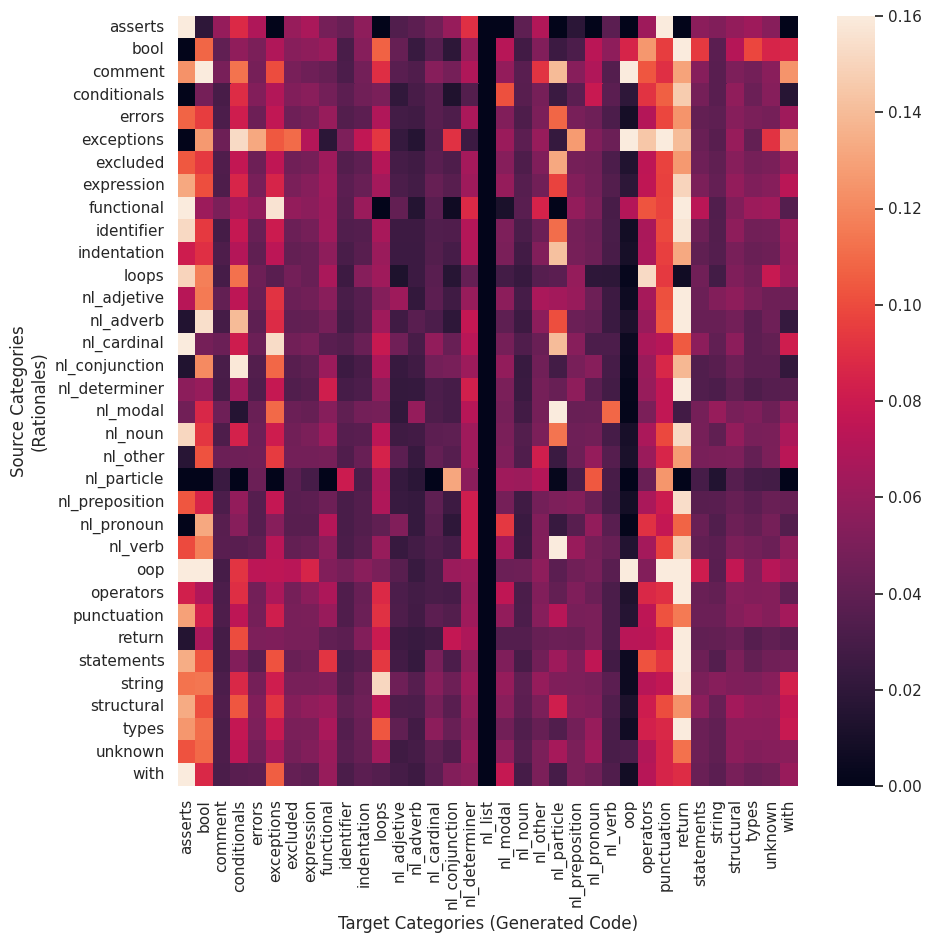

In [47]:
##### TARGET - CATEGORY ALL
##### SOURCE - CATEGORY ALL
target_elements = [category for categories in global_groups().values() for category in categories] #X
source_elements = [category for categories in global_groups().values() for category in categories] #Y
rationales_results = get_reduced_rationales_results('level_1', experiments_global_results, target_list=target_elements, source_list=source_elements)
print_heatmap(rationales_results, xlabel='Target Categories (Generated Code)', ylabel='Source Categories\n(Rationales)', fig_size=(10,10), font=10, vmax=0.16)

### Results all datasets



#### Modality SC
please uncomment bellow
{% ![level_1.png](captures/sc/level_1.png) %}

#### Modality NL_SC
please uncomment bellow
{%  ![level_1.png](captures/nl_sc/level_1.png) %}

## Experiment 1.4.2
Heatmap Dependency
>target - Level 2
>
>source - Level 2

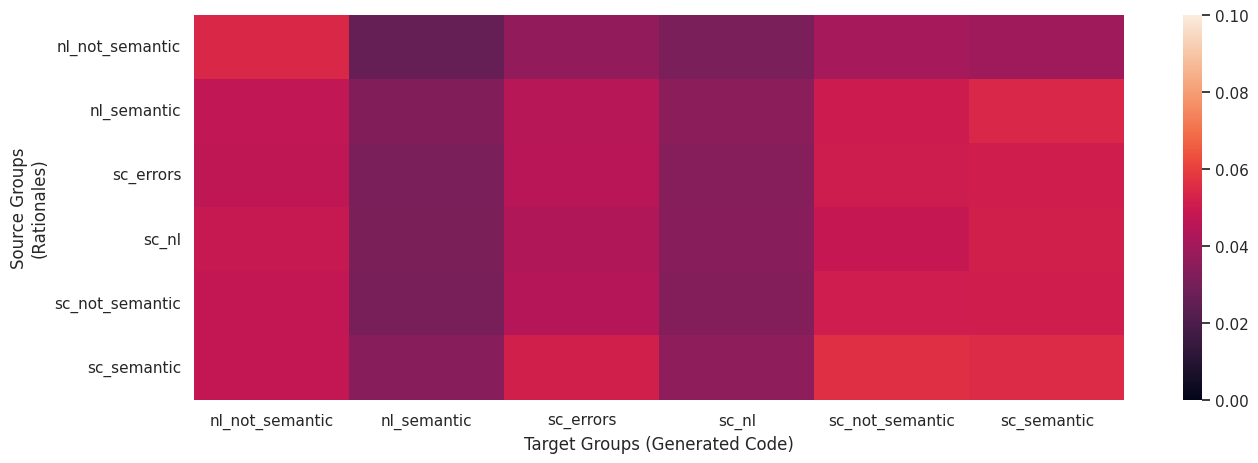

In [44]:
##### TARGET - GROUP 
##### SOURCE - GROUP
target_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #X
source_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #Y
rationales_results = get_reduced_rationales_results('level_2', global_results_groups_by_groups, target_list=target_elements, source_list=source_elements)
print_heatmap(rationales_results, xlabel='Target Groups (Generated Code)', ylabel='Source Groups\n(Rationales)', fig_size=(15,5), vmax=0.1)

### Results all datasets

#### Modality SC
please uncomment bellow
{% ![level_2.png](captures/nl_sc/level_2.png) %}

#### Modality NL_SC
please uncomment bellow
{% ![level_2.png](captures/sc/level_2.png) %}

## Experiment 1.4.3
Heatmap Dependency
>target - Level 1
>
>source - Level 2

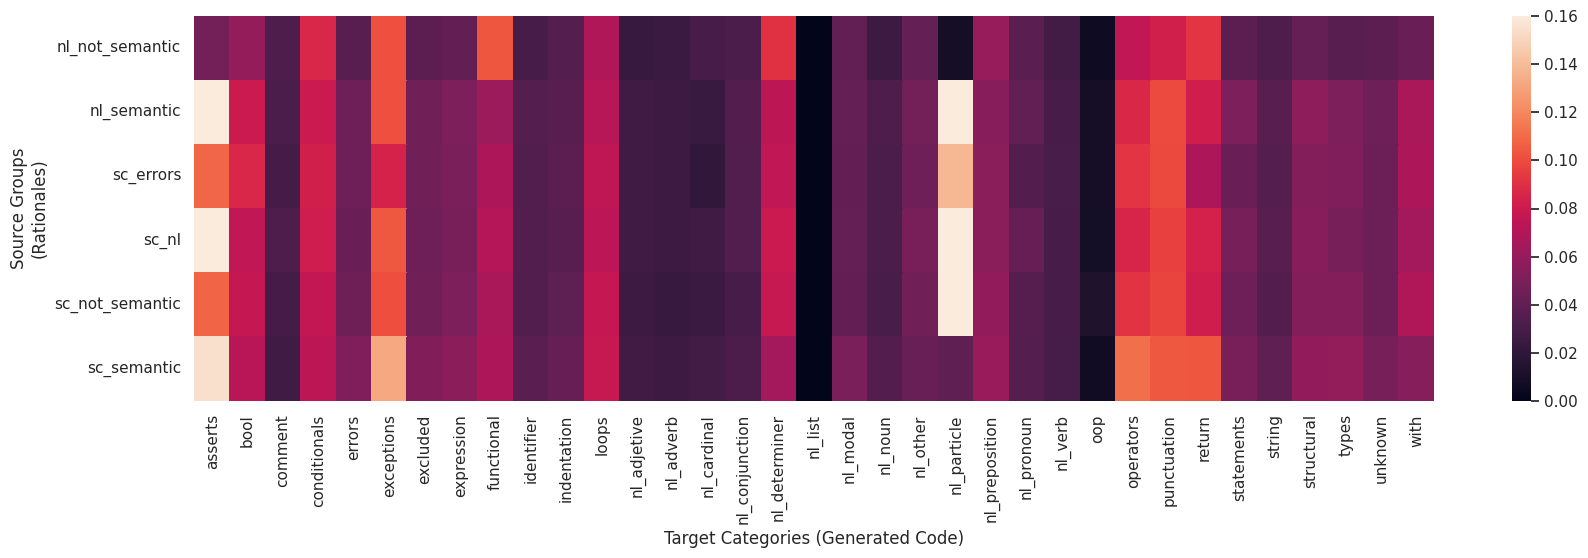

In [38]:
##### TARGET - CATEGORY 
##### SOURCE - GROUP
target_elements = [category for categories in global_groups().values() for category in categories] #X
source_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #Y
rationales_results = get_reduced_rationales_results('level_2_1', global_results_category_by_groups, target_list=target_elements, source_list=source_elements)
print_heatmap(rationales_results, xlabel='Target Categories (Generated Code)', ylabel='Source Groups\n(Rationales)', fig_size=(20,5), font=10 ,vmax=0.16)

### Results all Datasets

#### Modality SC
please uncomment bellow
{%![level_2_1.png](captures/nl_sc/level_2_1.png)%}

#### Modality NL_SC
{%![level_2_1.png](captures/sc/level_2_1.png)%}

## Experiment 1.4.3
Heatmap Dependency
>target - Level 2
>
>source - Level 1

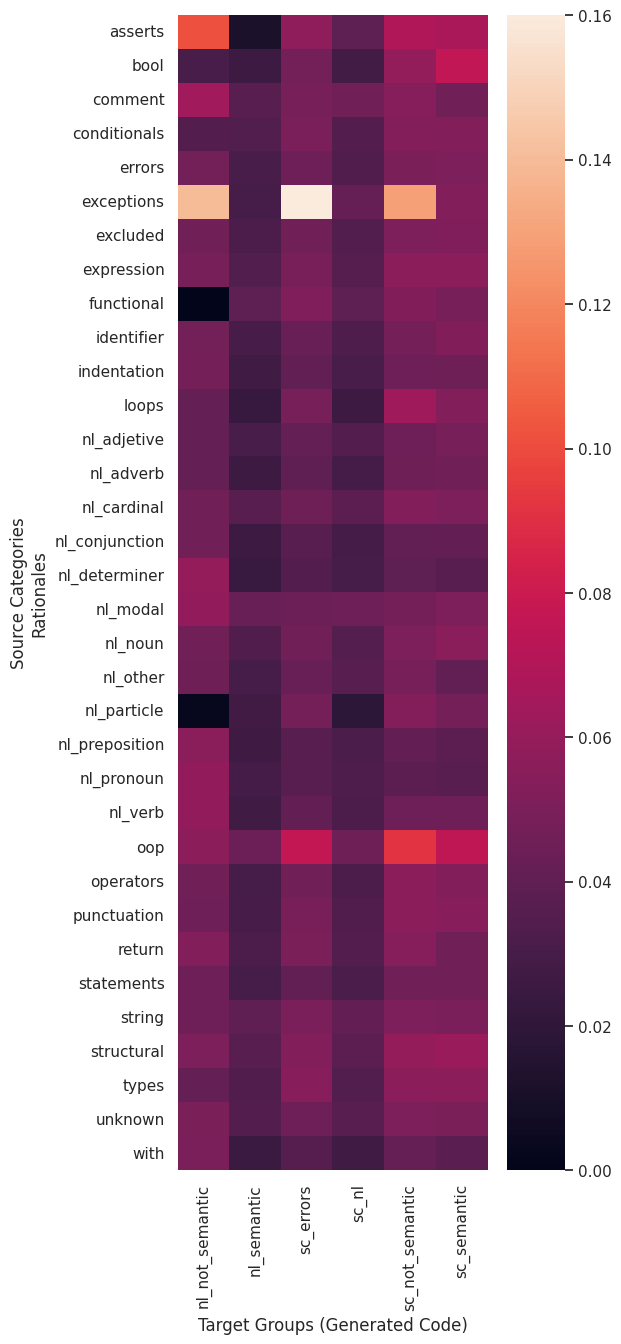

In [41]:
##### TARGET - GROUP 
##### SOURCE - CATEGORY
target_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #X
source_elements = [category for categories in global_groups().values() for category in categories] #Y
rationales_results = get_reduced_rationales_results('level_1_2', global_results_group_by_categories, target_list=target_elements, source_list=source_elements)
print_heatmap(rationales_results, xlabel='Target Groups (Generated Code)', ylabel='Source Categories\nRationales', fig_size=(5,15), vmax=0.16)

### Results all datasets

#### Modality SC
{%![level_1_2.png](captures/nl_sc/level_1_2.png)%}

#### Modality NL_SC
{%![level_1_2.png](captures/sc/level_1_2.png)%}